In [16]:
import sys
import scipy
import pandas as pd 
import numpy as np 
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
import statsmodels.formula.api as sm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv


In [17]:
import warnings  
warnings.filterwarnings('ignore')

'''The goal of this project is to build a model based on 11 predictors (predictive attributes), 
that allows us to determine the value an outcome variable. 
The attribute whose outcome value we will predict is "stroke", which tells us whether the
patient has had a stroke or not.

To calculate the value of "Stroke", we will use 11 explanatory variables:
    1) id: unique identifier
    2) gender: "Male", "Female" or "Other"
    3) age: age of the patient
    4) hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
    5) heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
    6) ever_married: "No" or "Yes"
    7) work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
    8) Residence_type: "Rural" or "Urban"
    9) avg_glucose_level: average glucose level in blood
    10) bmi: body mass index
    11) smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*
'''

In [18]:
#reading data
raw_data = pd.read_csv("/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv")
raw_data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [19]:
#Once the set is loaded, check its size and preview each observation to check if everything loaded correctly.:
raw_data.shape
print(str(raw_data.shape[0]) + ' rows.')
print(str(raw_data.shape[1]) + ' columns.')

5110 rows.
12 columns.


In [20]:
#Checking the types of each variable.:
raw_data.dtypes

id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [21]:
#This summary will be our starting point for further analysis.:
raw_data.describe().T


,count,mean,std,min,25%,50%,75%,max
id,5110.0,36517.829354,21161.721625,67.00,17741.250,36932.000,54682.00,72940.00
age,5110.0,43.226614,22.612647,0.08,25.000,45.000,61.00,82.00
hypertension,5110.0,0.097456,0.296607,0.00,0.000,0.000,0.00,1.00
heart_disease,5110.0,0.054012,0.226063,0.00,0.000,0.000,0.00,1.00
avg_glucose_level,5110.0,106.147677,45.283560,55.12,77.245,91.885,114.09,271.74
bmi,4909.0,28.893237,7.854067,10.30,23.500,28.100,33.10,97.60
stroke,5110.0,0.048728,0.215320,0.00,0.000,0.000,0.00,1.00


In [22]:
raw_data.columns

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [23]:
# Drop the id column
raw_data=raw_data.drop('id', axis=1)
raw_data.head()


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


Let's now focus on finding the missing values in the set. 

Let's check which variables are empty and how many empty variables there are.:

In [24]:
nulls_summary = pd.DataFrame(raw_data.isnull().any(), columns=['Nulls'])   
nulls_summary['Num_of_nulls [qty]'] = pd.DataFrame(raw_data.isnull().sum())   
nulls_summary['Num_of_nulls [%]'] = round((raw_data.isnull().mean()*100),2)
nulls_summary

,Nulls,Num_of_nulls [qty],Num_of_nulls [%]
gender,False,0,0.00
age,False,0,0.00
hypertension,False,0,0.00
heart_disease,False,0,0.00
ever_married,False,0,0.00
work_type,False,0,0.00
Residence_type,False,0,0.00
avg_glucose_level,False,0,0.00
bmi,True,201,3.93
smoking_status,False,0,0.00


In [25]:
str(round(raw_data.isnull().any(axis=1).sum()/raw_data.shape[0]*100,2))+'% observations contain missing values in the data..'

'3.93% observations contain missing values in the data..'

The only variable with 'Nan' values ​​is 'bmi' - 201 missing values, 
which is approximately 3.93% of all values ​​in this column.
Missing data can be handled as follows:
1)Delete rows with missing data.
2)Replacing missing values with estimated data.
    
As mentioned earlier, ignoring rows with missing data can lead to 
inconsistent results, since the deleted data may be critical for 
further calculations and may contain important observations.

In [26]:
#We replace the value of 'Nan'
#with the median of the other column values present in the dataset.

median = raw_data['bmi'].median()
print(median)
raw_data['bmi'].fillna(median, inplace=True)

28.1


In [27]:
#50% have a body mass index less than or equal to 28.1 and 
#the remaining 50% have a whole body mass index equal to or greater than 28.1.
raw_data

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.1,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,80.0,1,0,Yes,Private,Urban,83.75,28.1,never smoked,0
5106,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [28]:
#So now no 'Nan' values present in the data

raw_data.isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [29]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                5110 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


**Single variable analysis:
**
1) Analysis of numerical variables:

At this point, we will examine numerical variables. 
We will focus on analysing the charts to identify possible anomalies and detect outliers. 
Additionally, we will examine the distribution of the variables using the Scipy library.

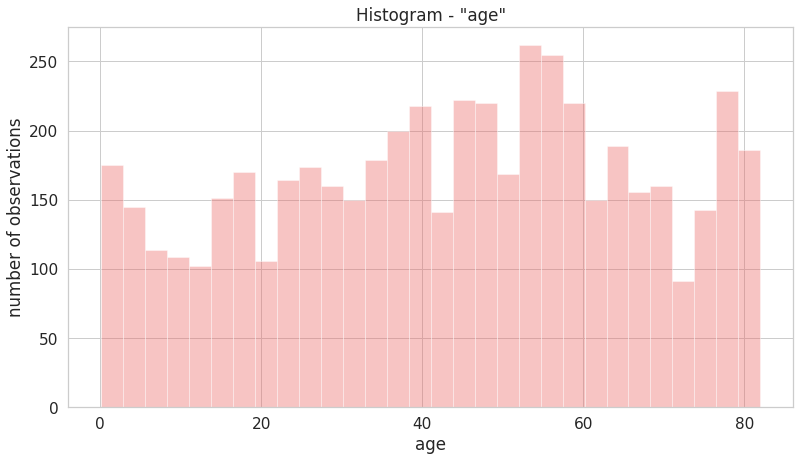

In [30]:
#The "age" variable:
# Histogram
plt.figure(figsize=(13,7))
sns.set(font_scale=1.4, style="whitegrid")
sns.distplot(raw_data['age'], kde = False, bins = 30, color = '#eb6c6a').set(title = 'Histogram - "age"', xlabel = 'age', ylabel = 'number of observations')
plt.show()

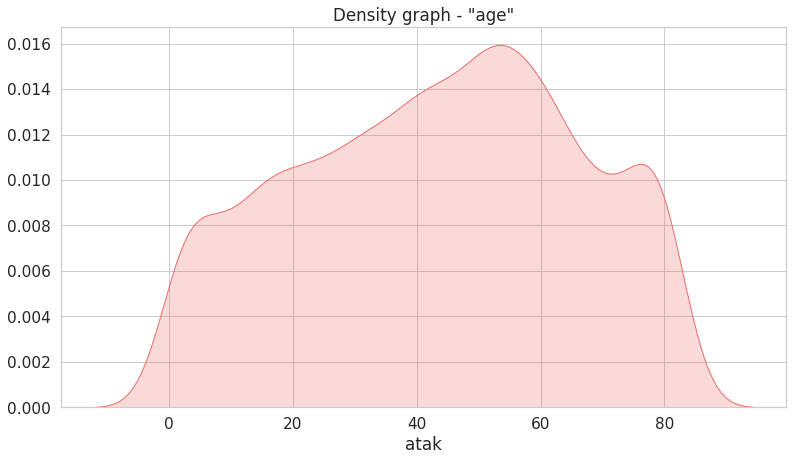

In [31]:
# Density graph
plt.figure(figsize=(13,7))
sns.set(font_scale=1.4, style="whitegrid")
sns.kdeplot(raw_data['age'], shade = True, color = '#eb6c6a').set(title = 'Density graph - "age"', xlabel = 'atak', ylabel = '')
plt.show()

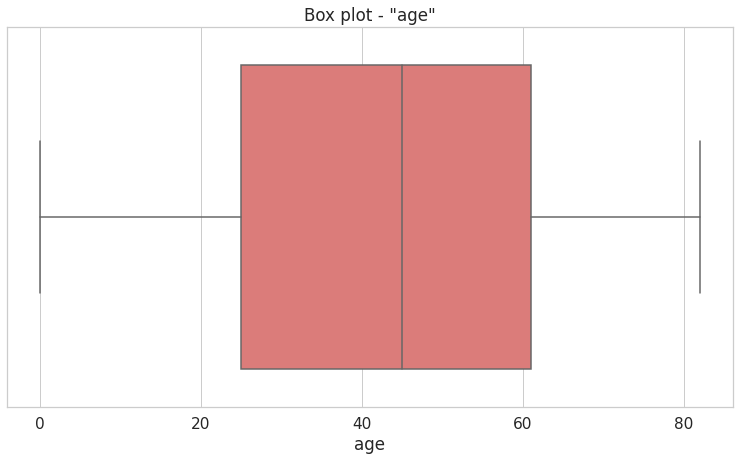

In [32]:
# Box plot
plt.figure(figsize=(13,7))
sns.set(font_scale=1.4, style="whitegrid")
sns.boxplot(raw_data['age'], color = '#eb6c6a').set(title = 'Box plot - "age"', xlabel = 'age')
plt.show()

In [33]:
# Test for normality of distribution
# Assumed significance level alpha = 0.05.
if(scipy.stats.normaltest(raw_data['age'])[1] < 0.05):
    print('The variable does not come from the normal distribution, therefore use an alternative assumption.')
else:
    print('The variable fits the normal distribution therefore use this assumption')

The variable does not come from the normal distribution, therefore use an alternative assumption.


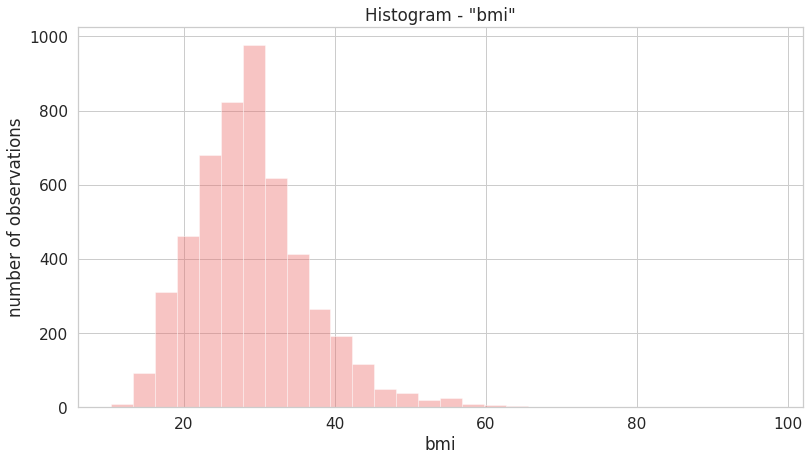

In [34]:
#The "bmi" variable:
# Histogram
plt.figure(figsize=(13,7))
sns.set(font_scale=1.4, style="whitegrid")
sns.distplot(raw_data['bmi'], kde = False, bins = 30, color = '#eb6c6a').set(title = 'Histogram - "bmi"', xlabel = 'bmi', ylabel = 'number of observations')
plt.show()

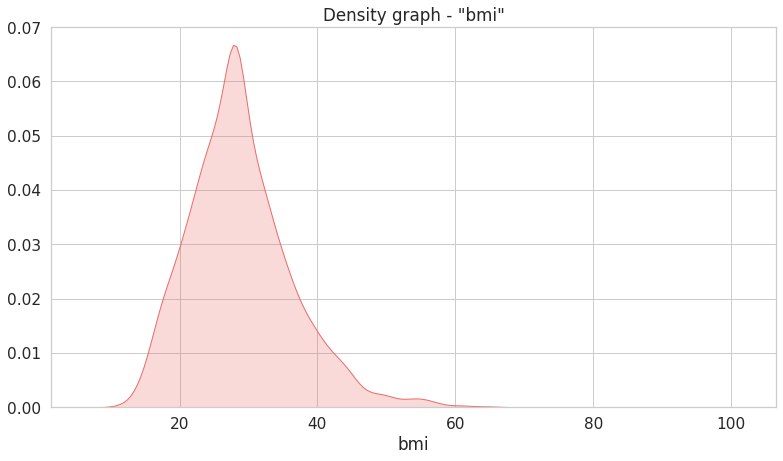

In [35]:
# Density graph
plt.figure(figsize=(13,7))
sns.set(font_scale=1.4, style="whitegrid")
sns.kdeplot(raw_data['bmi'], shade = True, color = '#eb6c6a').set(title = 'Density graph - "bmi"', xlabel = 'bmi', ylabel = '')
plt.show()

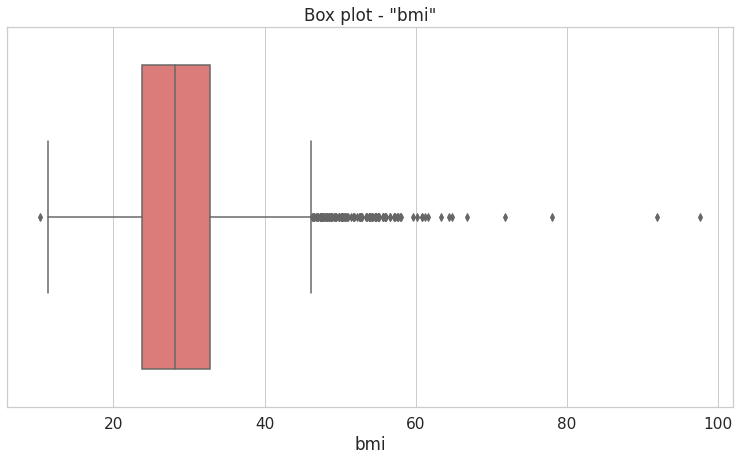

In [36]:
# Box plot
plt.figure(figsize=(13,7))
sns.set(font_scale=1.4, style="whitegrid")
sns.boxplot(raw_data['bmi'], color = '#eb6c6a').set(title = 'Box plot - "bmi"', xlabel = 'bmi')
plt.show()

In [37]:
# Test for normality of distribution
# Assumed significance level alpha = 0.05.
if(scipy.stats.normaltest(raw_data['bmi'])[1] < 0.05):
    print('The variable does not come from the normal distribution, therefore use an alternative assumption')
else:
    print('The variable fits the normal distribution therefore use this assumption')

The variable does not come from the normal distribution, therefore use an alternative assumption


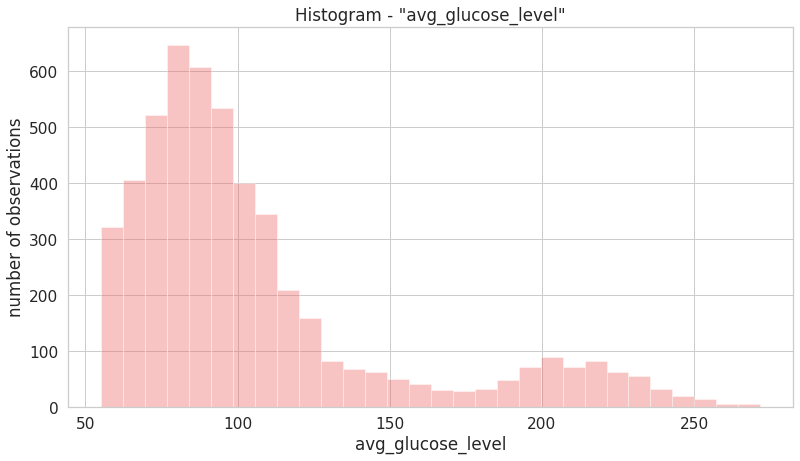

In [38]:
#The "avg_glucose_level" variable:
# Histogram
plt.figure(figsize=(13,7))
sns.set(font_scale=1.4, style="whitegrid")
sns.distplot(raw_data['avg_glucose_level'], kde = False, bins = 30, color = '#eb6c6a').set(title = 'Histogram - "avg_glucose_level"', xlabel = 'avg_glucose_level', ylabel = 'number of observations')
plt.show()

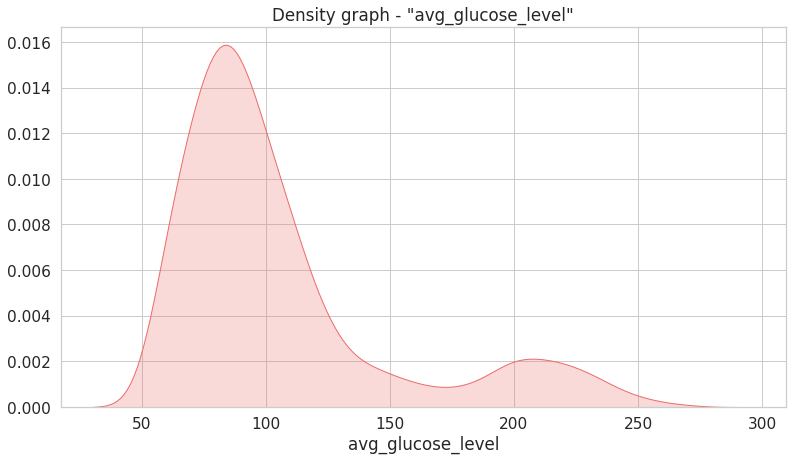

In [39]:
# Density graph
plt.figure(figsize=(13,7))
sns.set(font_scale=1.4, style="whitegrid")
sns.kdeplot(raw_data['avg_glucose_level'], shade = True, color = '#eb6c6a').set(title = 'Density graph - "avg_glucose_level"', xlabel = 'avg_glucose_level', ylabel = '')
plt.show()

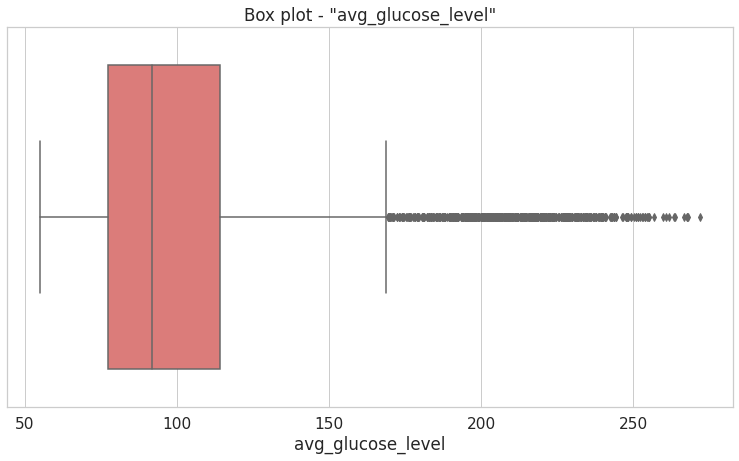

In [40]:
# Box plot
plt.figure(figsize=(13,7))
sns.set(font_scale=1.4, style="whitegrid")
sns.boxplot(raw_data['avg_glucose_level'], color = '#eb6c6a').set(title = 'Box plot - "avg_glucose_level"', xlabel = 'avg_glucose_level')
plt.show()

In [41]:
# Test for normality of distribution
# Assumed significance level alpha = 0.05.
if(scipy.stats.normaltest(raw_data['avg_glucose_level'])[1] < 0.05):
    print('The variable does not come from the normal distribution, therefore use an alternative assumption.')
else:
    print('The variable fits the normal distribution therefore use this assumption.')
    

The variable does not come from the normal distribution, therefore use an alternative assumption.


**Categorical variables:**
    
The „gender” variable:

In [42]:
print('Distribution of the "gender" variable:')
print(raw_data['gender'].value_counts(normalize = True))

Distribution of the "gender" variable:
Female    0.585910
Male      0.413894
Other     0.000196
Name: gender, dtype: float64


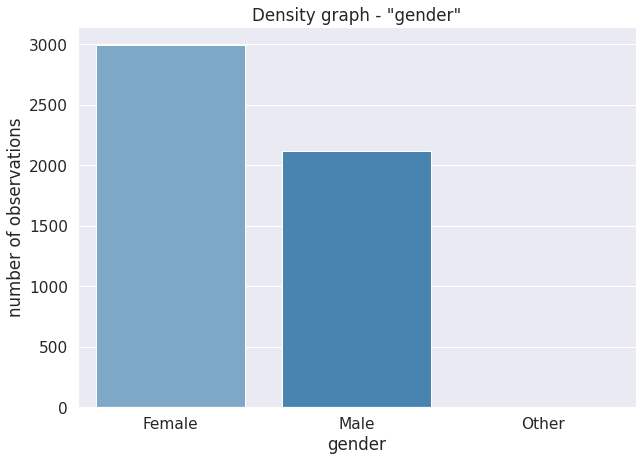

In [43]:
plt.figure(figsize=(10,7))
sns.set(font_scale=1.4)
sns.countplot(raw_data['gender'], palette = 'Blues_d', order = raw_data['gender'].value_counts().index).set(title = 'Density graph - "gender"', xlabel = 'gender', ylabel = 'number of observations')
plt.show()

The data consists of more women's data, although the gender difference is not huge.

In [44]:
#The „work_type” variable

print('Distribution of the "work_type" variable:')
print(raw_data['work_type'].value_counts(normalize = True))

Distribution of the "work_type" variable:
Private          0.572407
Self-employed    0.160274
children         0.134442
Govt_job         0.128571
Never_worked     0.004305
Name: work_type, dtype: float64


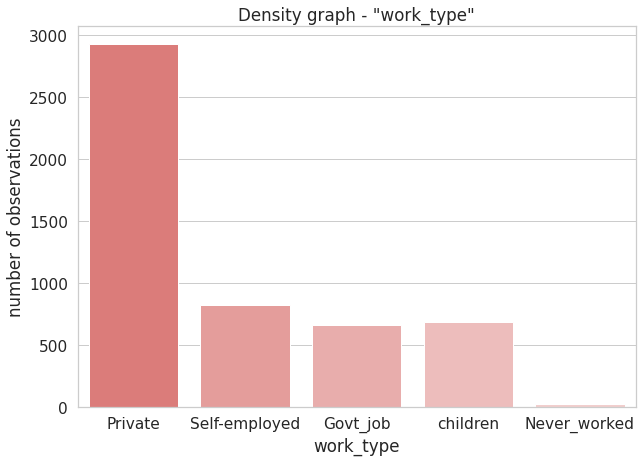

In [45]:
plt.figure(figsize=(10,7))
sns.set(font_scale=1.4, style="whitegrid")
sns.countplot(raw_data['work_type'], palette = ['#eb6c6a', '#f0918f', '#f2a3a2', '#f5b5b4', '#f7c8c7']).set(title = 'Density graph - "work_type"', xlabel = 'work_type', ylabel = 'number of observations')
plt.show()

We can see a large number of people work in the private sector.

In [46]:
#The „smoking_status” variable

print('Distribution of the "smoking_status" variable:')
print(raw_data['smoking_status'].value_counts(normalize = True))

Distribution of the "smoking_status" variable:
never smoked       0.370254
Unknown            0.302153
formerly smoked    0.173190
smokes             0.154403
Name: smoking_status, dtype: float64


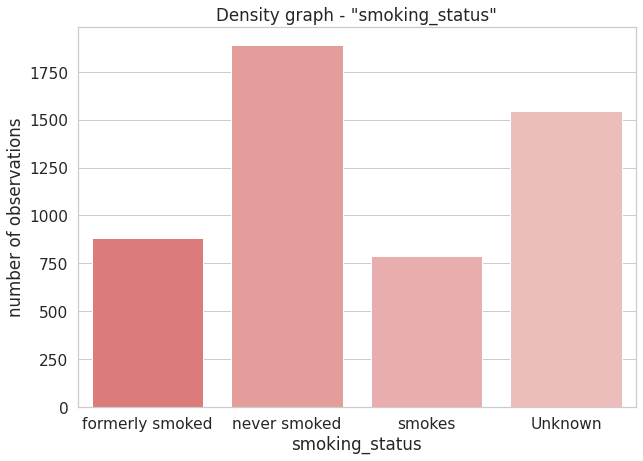

In [47]:
plt.figure(figsize=(10,7))
sns.set(font_scale=1.4, style="whitegrid")
sns.countplot(raw_data['smoking_status'], palette = ['#eb6c6a', '#f0918f', '#f2a3a2', '#f5b5b4', '#f7c8c7']).set(title = 'Density graph - "smoking_status"', xlabel = 'smoking_status', ylabel = 'number of observations')
plt.show()


WOW , nice to see that most of the people quoted don't smoke

In [48]:
#The „Residence_type” variable

print('Distribution of the "Residence_type" variable:')
print(raw_data['Residence_type'].value_counts(normalize = True))

Distribution of the "Residence_type" variable:
Urban    0.508023
Rural    0.491977
Name: Residence_type, dtype: float64


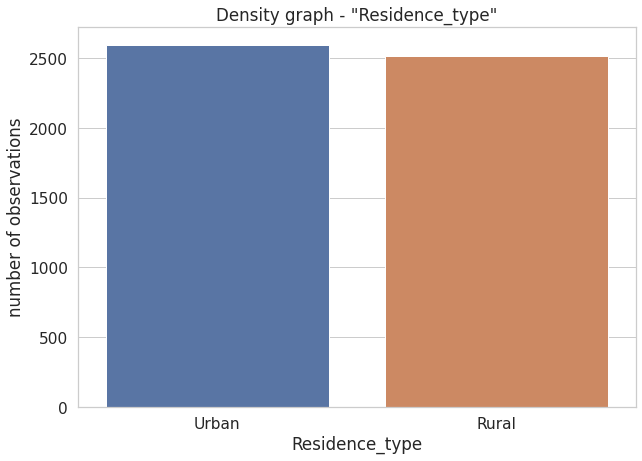

In [49]:
plt.figure(figsize=(10,7))
sns.set(font_scale=1.4, style="whitegrid")
sns.countplot(raw_data['Residence_type'], palette = "deep").set(title = 'Density graph - "Residence_type"', xlabel = 'Residence_type', ylabel = 'number of observations')
plt.show()

The minimal difference between people living in the city and rural.

In [50]:
#The „ever_married” variable

print('Distribution of the "ever_married" variable:')
print(raw_data['ever_married'].value_counts(normalize = True))


Distribution of the "ever_married" variable:
Yes    0.656164
No     0.343836
Name: ever_married, dtype: float64


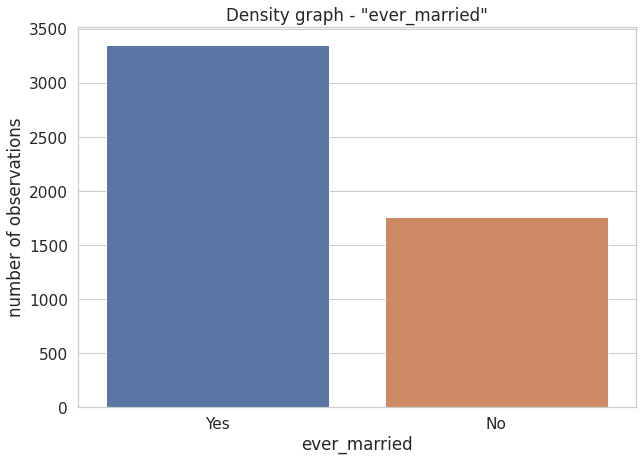

In [51]:
plt.figure(figsize=(10,7))
sns.set(font_scale=1.4,style="whitegrid")
sns.countplot(raw_data['ever_married'], palette="deep").set(title = 'Density graph - "ever_married"', xlabel = 'ever_married', ylabel = 'number of observations')
plt.show()

**Analysis of dependencies between variables:**
1) Correlation analysis between numerical variables:

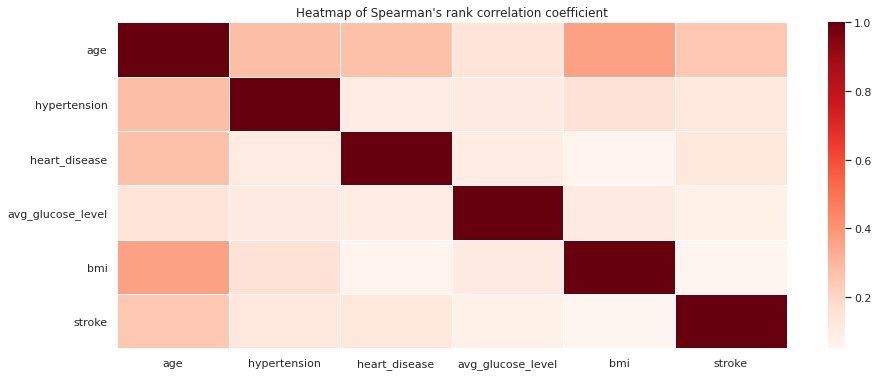

In [52]:
corr_num = pd.DataFrame(scipy.stats.spearmanr(raw_data.select_dtypes(include = ['float', 'int']))[0],
                        columns = raw_data.select_dtypes(include = ['float', 'int']).columns,
                        index = raw_data.select_dtypes(include = ['float', 'int']).columns)

plt.figure(figsize=(15,6))
sns.set(font_scale=1)
sns.heatmap(corr_num.abs(), cmap="Reds", linewidths=.5).set(title="Heatmap of Spearman's rank correlation coefficient")
plt.show()

 2)Analysis of the relationship between categorical variables:

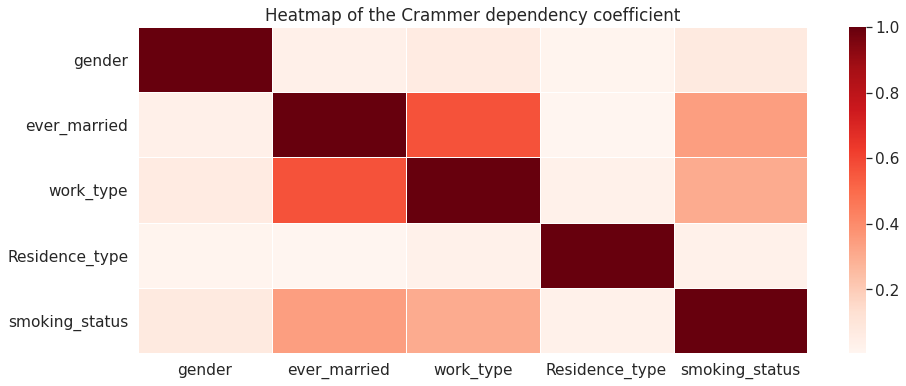

In [53]:
def CramersV(tab):
    a = scipy.stats.chi2_contingency(tab)[0]/sum(tab.sum())
    b = min(tab.shape[0]-1, tab.shape[1]-1,)
    return(np.sqrt(a/b))

def CalculateCrammersV(tab):
    ret = []
    for m in tab:
        row = []
        for n in tab:
            cross_tab = pd.crosstab(tab[m].values,tab[n].values)
            row.append(CramersV(cross_tab))
        ret.append(row)
    return pd.DataFrame(ret, columns=tab.columns, index=tab.columns)
crammer = CalculateCrammersV(raw_data[['gender', 'ever_married', 'work_type','Residence_type','smoking_status']])

plt.figure(figsize=(15,6))
sns.set(font_scale=1.4)
sns.heatmap(crammer, cmap="Reds", linewidths=.5).set(title='Heatmap of the Crammer dependency coefficient')
plt.show()

Now we will remove the value "Other" from the variable "Gender", 
because we are only interested in the concrete variable "Gender"

In [54]:
raw_data = raw_data[raw_data["gender"].str.contains("Other")==False]


The next step is to change the values of the categorical variables to have numerical values.

In [55]:
raw_data['gender'] = raw_data['gender'].map({'Male':0, 'Female':1})
raw_data['Residence_type'] = raw_data['Residence_type'].map({'Urban':0, 'Rural':1})
raw_data['smoking_status'] = raw_data['smoking_status'].map({'formerly smoked':2, 'never smoked':0, 'smokes':1, 'Unknown':3})
raw_data['ever_married'] = raw_data['ever_married'].map({'Yes':1, 'No':0})
raw_data['work_type'] = raw_data['work_type'].map({'Private':0, 'Self-employed': 1, 'Govt_job':2, 'children':3, 'Never_worked':4})
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5109 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5109 non-null   int64  
 1   age                5109 non-null   float64
 2   hypertension       5109 non-null   int64  
 3   heart_disease      5109 non-null   int64  
 4   ever_married       5109 non-null   int64  
 5   work_type          5109 non-null   int64  
 6   Residence_type     5109 non-null   int64  
 7   avg_glucose_level  5109 non-null   float64
 8   bmi                5109 non-null   float64
 9   smoking_status     5109 non-null   int64  
 10  stroke             5109 non-null   int64  
dtypes: float64(3), int64(8)
memory usage: 479.0 KB


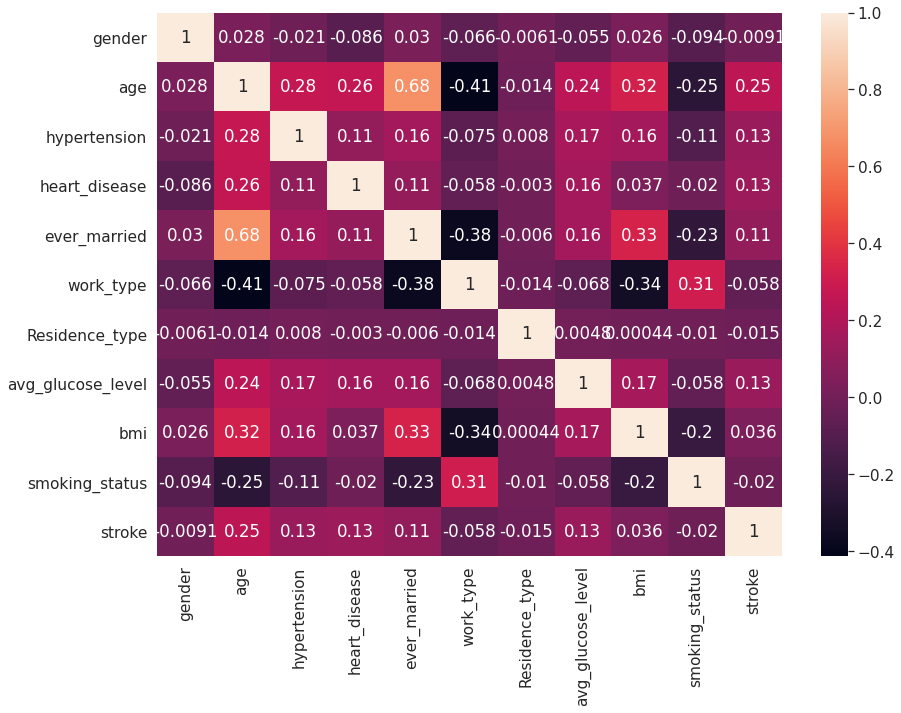

In [56]:
#plot heat map
plt.figure(figsize=(14,10))
sns.heatmap(raw_data.corr(method='pearson'), annot=True)
plt.show() 

From the map we can see negative correlation between age and work_type,
  also work_type and bmi. Stroke and age has a positive correlation similarly. Many other variables
  have such correlation values so we cannot remove any variables.
  
  Let see which gender is more at risk to having a stroke. The boxplot will be help for us:

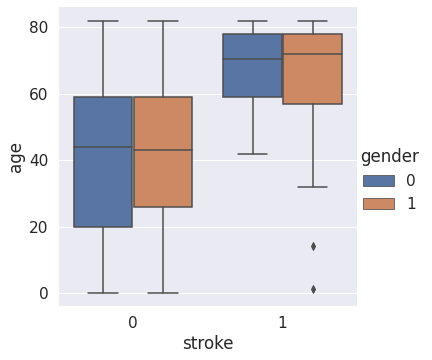

In [57]:
sns.catplot(x='stroke', y="age", hue = 'gender', kind="box", data=raw_data)

We can see that older females are more at risk to having a stroke.

In [58]:
## Now we want built a model so we split the data into X and Y planes:
X = raw_data.drop(['stroke'], axis=1)
Y = raw_data.stroke

X.head()
Y.head()

0    1
1    1
2    1
3    1
4    1
Name: stroke, dtype: int64

In [59]:
print(f'X shape: {X.shape}')
print(f'Y shape: {Y.shape}')

X shape: (5109, 10)
Y shape: (5109,)


In [60]:
#Split the dataset into training and test datasets.
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((3831, 10), (1278, 10), (3831,), (1278,))

In [61]:
#Build a the base model
baseline_model = Sequential()
baseline_model.add(Dense(10, activation='relu', input_shape=(X_train.shape[1],)))
baseline_model.add(Dense(7, activation='relu'))
baseline_model.add(Dense(1, activation='sigmoid'))

Above I used the simplest dense layer, combining all the units of the previous layer with all of the next.


In [62]:
baseline_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
baseline_history = baseline_model.fit(X_train, Y_train, epochs=100, batch_size=30, verbose=0)

In [63]:
#Evaluate the accuracy of the model based on the test dataset.
loss, acc = baseline_model.evaluate(X_test, Y_test, verbose=0)
print('Test accuracy: %.3f' % acc)


Test accuracy: 0.952


I think that is a good test accuracy. Next, let us discuss K-fold Cross
 Validation.

In [64]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold

# Define the K-fold Cross Validator

kfold = KFold(n_splits=10, shuffle=True)
acc_per_fold =[]
loss_per_fold=[]

In [65]:
#K-fold Cross Validation model evaluation
fold_no = 1
'X shape: {X.shape}'

  

'X shape: {X.shape}'

In [66]:
for train, test in kfold.split(X, Y):
    
  train=[x for x in train.tolist() if x in X.index.values.tolist()]
  test=[x for x in test.tolist() if x in X.index.values.tolist()]
  
  # Define the model architecture
  model = Sequential()
  model.add(Dense(10, activation='relu', input_shape=(X_train.shape[1],)))
  model.add(Dense(7, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))


  # Compile the model
  model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')
  
  # Fit data to model
  history = model.fit(X.loc[train], Y.loc[train],
              batch_size=30,
              epochs=15,
              verbose=1)
  '''We next replace the “test loss” print with one related to what we’re doing. 
  Also, we increase the fold_no:'''
  # Generate generalization metrics
  scores = model.evaluate(X.loc[train], Y.loc[train], verbose=1)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Increase fold number
  fold_no = fold_no + 1
# == Provide average scores ==
  print('------------------------------------------------------------------------')
  print('Score per fold')


------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/15
154/154 [==============================] - 1s 1ms/step - loss: 3.0838 - accuracy: 0.9588
Epoch 2/15
154/154 [==============================] - 0s 1ms/step - loss: 0.6257 - accuracy: 0.9506
Epoch 3/15
154/154 [==============================] - 0s 1ms/step - loss: 0.2148 - accuracy: 0.9515
Epoch 4/15
154/154 [==============================] - 0s 1ms/step - loss: 0.2052 - accuracy: 0.9492
Epoch 5/15
154/154 [==============================] - 0s 1ms/step - loss: 0.1799 - accuracy: 0.9514
Epoch 6/15
154/154 [==============================] - 0s 1ms/step - loss: 0.1800 - accuracy: 0.9525
Epoch 7/15
154/154 [==============================] - 0s 1ms/step - loss: 0.1641 - accuracy: 0.9563
Epoch 8/15
154/154 [==============================] - 0s 1ms/step - loss: 0.1859 - accuracy: 0.9492
Epoch 9/15
154/154 [==============================] - 0s 1ms/step - loss: 0.1862 - accuracy: 0.9478
Epo

In [67]:
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
> Fold 1 - Loss: 0.1714068502187729 - Accuracy: 95.14901041984558%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.17500895261764526 - Accuracy: 94.9543297290802%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.17130929231643677 - Accuracy: 95.10550498962402%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.17500057816505432 - Accuracy: 94.67043876647949%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.1808343231678009 - Accuracy: 94.3441390991211%
------------------------------------------------------------------------
> Fold 6 - Loss: 0.16988013684749603 - Accuracy: 95.2360212802887%
------------------------------------------------------------------------
> Fold 7 - Loss: 0.17129281163215637 - Accuracy: 94.88797187805176%
------------------